In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

#Data Preparation
IMG_SIZE=32

train_set = keras.utils.image_dataset_from_directory(
    'train/snail/',
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

test_set = keras.utils.image_dataset_from_directory(
    'test/snail/',
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

x_train = np.concatenate([x.numpy() for x in train_set], axis=0)
x_test = np.concatenate([x.numpy() for x in test_set], axis=0)
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 

x_train.shape

Found 500 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


(500, 32, 32, 3)

In [2]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
# a. Construct and train a deep learning model as an image generator

input_layer = Input(shape=(32, 32, 3)) 

#ENCODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

bottleneck = MaxPooling2D((2, 2), padding='same', name='latent_space')(x)

# DECODER
x = Conv2D(8, (3, 3), activation='relu', padding='same')(bottleneck)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded) 

autoencoder.compile(optimizer='adam', loss='binary_crossentropy') 
autoencoder.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           1160  

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [4]:
history = autoencoder.fit(
    x_train, x_train,  
    epochs=1000,  
    batch_size=256,  
    shuffle=True,  
    validation_data=(x_test, x_test),
    callbacks = [early_stopping]
)

Epoch 1/1000
2/2 [==============================] - 2s 702ms/step - loss: 0.6923 - val_loss: 0.6904
Epoch 2/1000
2/2 [==============================] - 1s 254ms/step - loss: 0.6903 - val_loss: 0.6867
Epoch 3/1000
2/2 [==============================] - 1s 407ms/step - loss: 0.6870 - val_loss: 0.6835
Epoch 4/1000
2/2 [==============================] - 1s 429ms/step - loss: 0.6857 - val_loss: 0.6817
Epoch 5/1000
2/2 [==============================] - 1s 264ms/step - loss: 0.6836 - val_loss: 0.6797
Epoch 6/1000
2/2 [==============================] - 1s 264ms/step - loss: 0.6812 - val_loss: 0.6779
Epoch 7/1000
2/2 [==============================] - 1s 265ms/step - loss: 0.6792 - val_loss: 0.6744
Epoch 8/1000
2/2 [==============================] - 1s 341ms/step - loss: 0.6757 - val_loss: 0.6708
Epoch 9/1000
2/2 [==============================] - 1s 305ms/step - loss: 0.6715 - val_loss: 0.6663
Epoch 10/1000
2/2 [==============================] - 0s 263ms/step - loss: 0.6674 - val_loss: 0.6626

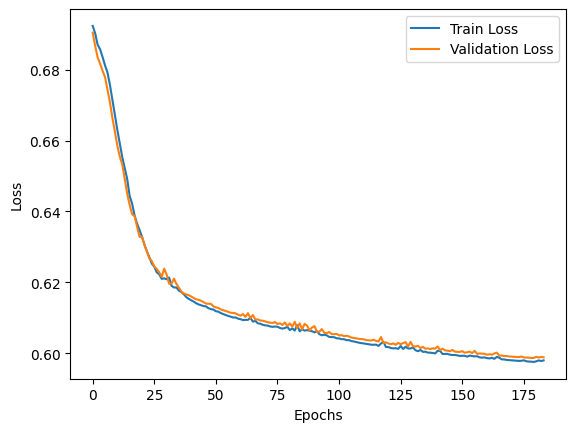

In [5]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Pelatihan berjalan selama 172 epoch. Di beberapa epoch awal, Training dan validation loss berkurang dengan pesat yang artinya model dapat belajar memperbaiki gambar yang dihasilkan dengan cepat di awal. Kemudian pada epochs selanjutnya, validation loss berkurang dengan perlahan hingga akhirnya dihentikan oleh fungsi early_stopping. Nilai validation dan training loss dekat dengan satu sama lain dari awal hingga akhir pelatihan.

16/16 [==============================] - 0s 11ms/step


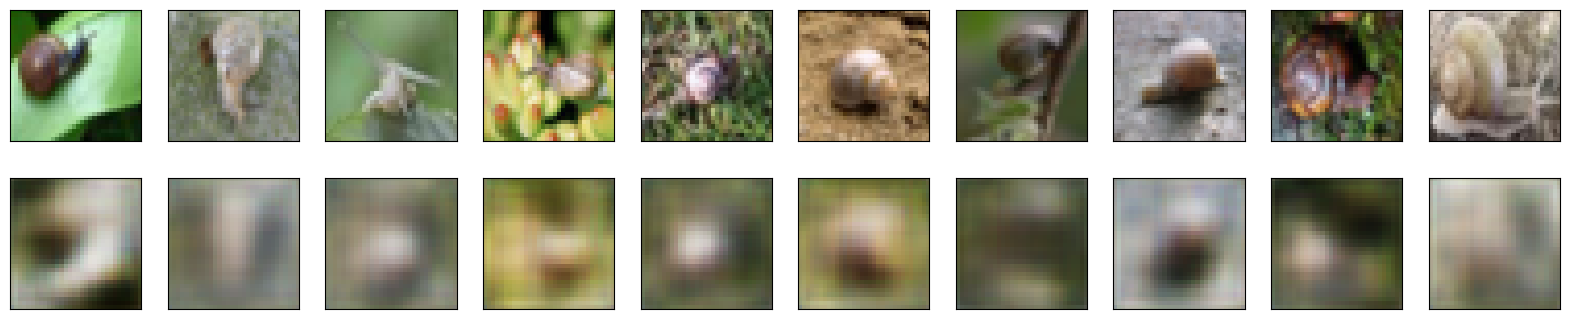

In [6]:
# b. Generate 500 images by using the trained model from point a
reconstructed = autoencoder.predict(x_train) 

# c. Compare 10 generated images and 10 original images, analyze and explain the comparison.
n = 10  
plt.figure(figsize=(20, 4)) 

for i in range(n): 
    # Display original 
    ax = plt.subplot(2, n, i + 1) 
    plt.imshow(x_train[i]) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

    # Display reconstruction 
    ax = plt.subplot(2, n, i + 1 + n) 
    plt.imshow(reconstructed[i]) 
    plt.gray() 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

plt.show()


Gambar yang dihasilkan terlihat seperti versi blur/kabur dari gambar aslinya. Model dapat menangkap skema warna siput dan latar belakang. 

In [7]:
#e. Construct a new dataset for classification with 2 classes: original and fake
labels_original = np.ones(len(x_train))  
labels_reconstructed = np.zeros(len(reconstructed)) 

X_combined = np.concatenate([x_train, reconstructed], axis=0)
y_combined = np.concatenate([labels_original, labels_reconstructed], axis=0)

indices = np.arange(len(X_combined))
np.random.shuffle(indices)
X_combined = X_combined[indices]
y_combined = y_combined[indices]

print(f"X_combined shape: {X_combined.shape}")
print(f"y_combined shape: {y_combined.shape}")

X_combined shape: (1000, 32, 32, 3)
y_combined shape: (1000,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=0.3, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.initializers import HeUniform

# f. Construct and train a deep learning model to classify original versus fake images

# Construct classifier model
classifier_model = Sequential([
                    Conv2D(32 , (3,3) , activation="relu",padding="same",strides=(1,1), input_shape=(32, 32, 3)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(64, (3,3) , activation="relu",padding="same" , strides=(1,1)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(128, (3,3) , activation="relu",padding="same" ,strides=(1,1)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(256, (3,3) , activation="relu",padding="same" ,strides=(1,1)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    GlobalAveragePooling2D(),
                    
                    Dense(64,activation="relu" ),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(128,activation="relu" ),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(256,activation="relu" ),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    
                    Dense(1 , activation="sigmoid")
                    
                ])

classifier_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                        

In [10]:
# Train the classifier
classifier_history = classifier_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
22/22 [==============================] - 5s 75ms/step - loss: 0.3919 - accuracy: 0.8229 - val_loss: 0.6906 - val_accuracy: 0.4800
Epoch 2/50
22/22 [==============================] - 1s 50ms/step - loss: 0.1666 - accuracy: 0.9343 - val_loss: 0.6836 - val_accuracy: 0.4800
Epoch 3/50
22/22 [==============================] - 1s 50ms/step - loss: 0.0783 - accuracy: 0.9657 - val_loss: 0.7144 - val_accuracy: 0.4867
Epoch 4/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0708 - accuracy: 0.9771 - val_loss: 0.8770 - val_accuracy: 0.4800
Epoch 5/50
22/22 [==============================] - 1s 47ms/step - loss: 0.0387 - accuracy: 0.9871 - val_loss: 0.8288 - val_accuracy: 0.4933
Epoch 6/50
22/22 [==============================] - 1s 49ms/step - loss: 0.0198 - accuracy: 0.9929 - val_loss: 0.4584 - val_accuracy: 0.8467
Epoch 7/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0615 - accuracy: 0.9800 - val_loss: 1.2913 - val_accuracy: 0.4933
Epoch 8/50
22

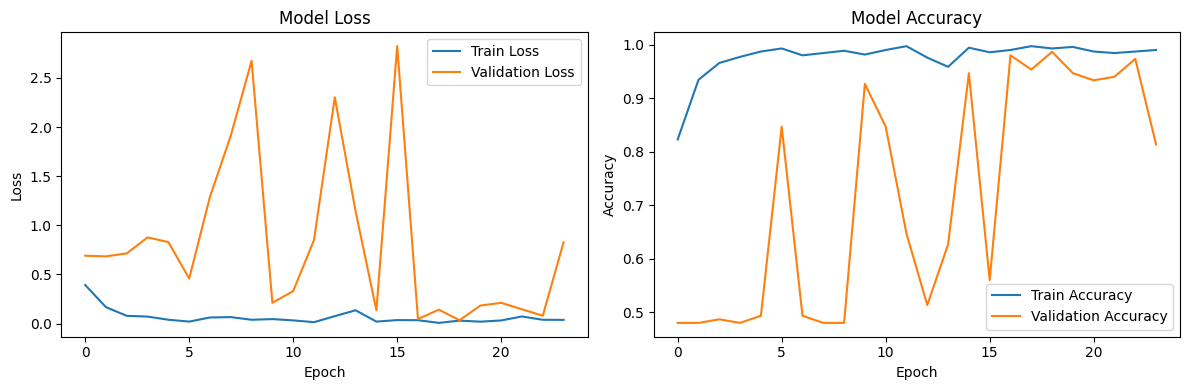

In [11]:
# g. Plot the training and validation losses over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(classifier_history.history['loss'], label='Train Loss')
plt.plot(classifier_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(classifier_history.history['accuracy'], label='Train Accuracy')
plt.plot(classifier_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Terlihat adanya overfitting. Nilai validation loss lebih besar dari training loss, dan nilai valiadation accuracy lebih kecil dari train accuracy. Perbedaan kedua nilai cukup signifikan.

In [12]:
!pip install keras-tuner==1.4.7
import keras_tuner as kt

In [ ]:
# h. Do hyperparameter tuning to improve the deep learning model

from tensorflow.keras.optimizers import Adam

def build_model(hp):
    improved_classifier_model = Sequential([
                    Conv2D(32 , (3,3) , activation="relu",padding="same",strides=(1,1), kernel_initializer=HeUniform(), input_shape=(32, 32, 3)),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(64, (3,3) , activation="relu",padding="same" , strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(128, (3,3) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    Conv2D(256, (3,3) , activation="relu",padding="same" ,strides=(1,1), kernel_initializer=HeUniform()),
                    MaxPooling2D(2,2),
                    BatchNormalization(),
                    
                    GlobalAveragePooling2D(),
                    
                    Dense(hp.Int('unit_1', min_value=32, max_value=256, step=32),activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(hp.Int('unit_2', min_value=32, max_value=256, step=32),activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(hp.Int('unit_3', min_value=32, max_value=256, step=32),activation="relu" , kernel_initializer=HeUniform()),
                    BatchNormalization(),
                    Dropout(0.4),
            
                    Dense(1 , activation="sigmoid")
                ])

    improved_classifier_model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return improved_classifier_model

In [14]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_tuning',
    project_name='orginal_fake'
)

tuner.search_space_summary()


Reloading Tuner from kt_tuning\orginal_fake\tuner0.json
Search space summary
Default search space size: 4
unit_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
unit_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
unit_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [15]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val)) 

tuner.results_summary() 

Results summary
Results in kt_tuning\orginal_fake
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
unit_1: 128
unit_2: 64
unit_3: 256
learning_rate: 0.0039426799290831925
Score: 0.8799999952316284

Trial 05 summary
Hyperparameters:
unit_1: 128
unit_2: 64
unit_3: 224
learning_rate: 0.0035868505805301547
Score: 0.8533333539962769

Trial 14 summary
Hyperparameters:
unit_1: 256
unit_2: 224
unit_3: 224
learning_rate: 0.0006789302083203084
Score: 0.8500000238418579

Trial 01 summary
Hyperparameters:
unit_1: 256
unit_2: 160
unit_3: 192
learning_rate: 0.00392551860940815
Score: 0.8466666638851166

Trial 10 summary
Hyperparameters:
unit_1: 128
unit_2: 128
unit_3: 32
learning_rate: 0.00016803479725592616
Score: 0.8333333432674408

Trial 02 summary
Hyperparameters:
unit_1: 96
unit_2: 32
unit_3: 160
learning_rate: 0.008053623177641262
Score: 0.8299999833106995

Trial 03 summary
Hyperparameters:
unit_1: 224
unit_2: 224
unit_3: 64
learning_rat

In [16]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] 
improved_model = tuner.hypermodel.build(best_hps) 
improved_history = improved_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
22/22 [==============================] - 4s 71ms/step - loss: 0.3298 - accuracy: 0.8614 - val_loss: 0.4713 - val_accuracy: 0.8200
Epoch 2/50
22/22 [==============================] - 1s 44ms/step - loss: 0.1110 - accuracy: 0.9657 - val_loss: 1.7865 - val_accuracy: 0.7133
Epoch 3/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0763 - accuracy: 0.9757 - val_loss: 0.4582 - val_accuracy: 0.8400
Epoch 4/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0906 - accuracy: 0.9714 - val_loss: 3.6677 - val_accuracy: 0.5533
Epoch 5/50
22/22 [==============================] - 1s 47ms/step - loss: 0.0596 - accuracy: 0.9843 - val_loss: 6.3545 - val_accuracy: 0.5000
Epoch 6/50
22/22 [==============================] - 1s 46ms/step - loss: 0.0545 - accuracy: 0.9857 - val_loss: 3.3362 - val_accuracy: 0.5800
Epoch 7/50
22/22 [==============================] - 1s 47ms/step - loss: 0.0786 - accuracy: 0.9800 - val_loss: 0.4365 - val_accuracy: 0.8067
Epoch 8/50
22

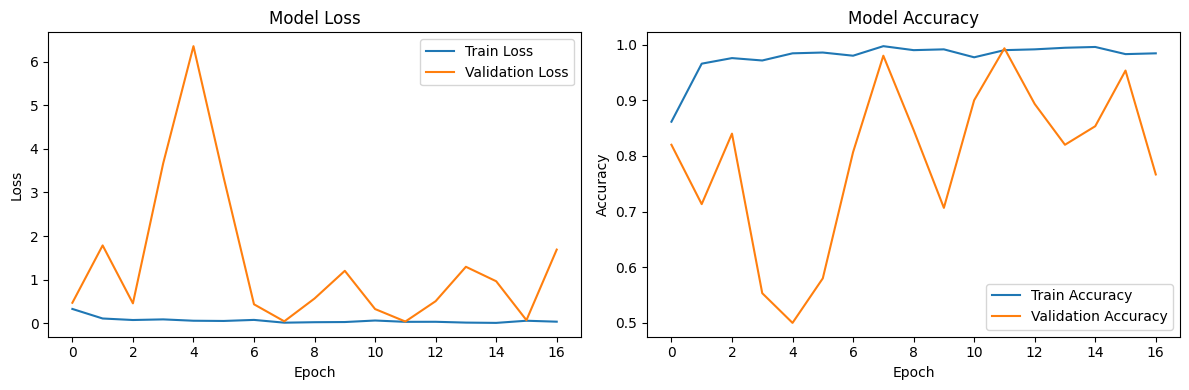

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(improved_history.history['loss'], label='Train Loss')
plt.plot(improved_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(improved_history.history['accuracy'], label='Train Accuracy')
plt.plot(improved_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import classification_report


loss, accuracy = improved_model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_proba = improved_model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Reconstructed (0)', 'Original (1)']))


5/5 [==============================] - 0s 13ms/step - loss: 0.0576 - accuracy: 0.9867

Test Loss: 0.0576
Test Accuracy: 0.9867

Classification Report:
                   precision    recall  f1-score   support

Reconstructed (0)       0.97      1.00      0.99        69
     Original (1)       1.00      0.98      0.99        81

         accuracy                           0.99       150
        macro avg       0.99      0.99      0.99       150
     weighted avg       0.99      0.99      0.99       150

